Import all necessary packages and functions

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import load_npz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score



In [23]:
# Load data
X_train = load_npz("X_train_sparse.npz")
X_test = load_npz("X_test_sparse.npz")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [24]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)
nb_probs = nb_model.predict_proba(X_test)[:, 1]

# Poor Man's Stacking
We will be performing error-based model ensemble. This is a post-hoc evaluation, not a deployable model.

In [25]:
ensemble_preds = []
ensemble_probs = []

for i in range(len(y_test)):
    if lr_preds[i] == nb_preds[i]:
        # Both agree
        prob = (lr_probs[i] + nb_probs[i]) / 2
    elif lr_preds[i] == y_test[i] and nb_preds[i] != y_test[i]:
        prob = lr_probs[i]
    elif nb_preds[i] == y_test[i] and lr_preds[i] != y_test[i]:
        prob = nb_probs[i]
    else:
        # Both wrong: default to baseline model LR
        prob = lr_probs[i]

    pred = 1 if prob >= 0.5 else 0

    ensemble_probs.append(prob)
    ensemble_preds.append(pred)

ensemble_probs = np.array(ensemble_probs)
ensemble_preds = np.array(ensemble_preds)


=== Log Regression and Naive Bayes Model Ensemble Performance ===
Accuracy:  0.9886
Precision: 0.9859
Recall:    0.9901
F1 Score:  0.9880
AUC:       0.9975


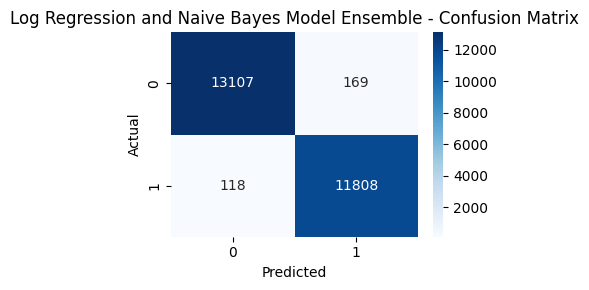

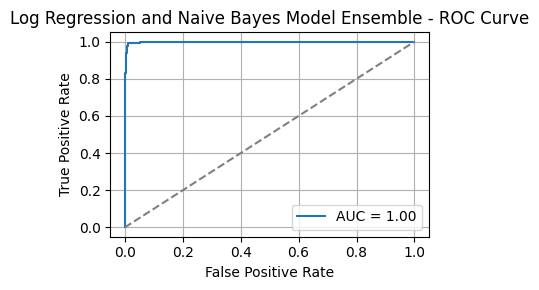

In [26]:
acc = accuracy_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds)
rec = recall_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, ensemble_preds)

print(f"\n=== {"Log Regression and Naive Bayes Model Ensemble Performance"} ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{"Log Regression and Naive Bayes Model Ensemble"} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{"Log Regression and Naive Bayes Model Ensemble"} - ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Deployable Confidence + Weight based Ensemble
Let's now look at Confidence-based and Weighted Averaging Ensemble. This is deployable and a creative way of combining the best of both worlds. A simple gridsearch will help to determine the thresholds and weights to use.

In [27]:
thresholds = np.arange(0.5, 0.9, 0.005)
weights = np.arange(0.1, 1.0, 0.01)

best_result = {"f1": 0}
results = []

for threshold in thresholds:
    for w_lr in weights:
        w_nb = 1 - w_lr
        ensemble_probs = []
        ensemble_preds = []

        for i in range(len(y_test)):
            if lr_probs[i] >= threshold:
                prob = lr_probs[i]
            elif nb_probs[i] >= threshold:
                prob = nb_probs[i]
            else:
                prob = w_lr * lr_probs[i] + w_nb * nb_probs[i]

            pred = 1 if prob >= 0.5 else 0
            ensemble_probs.append(prob)
            ensemble_preds.append(pred)

        ensemble_probs = np.array(ensemble_probs)
        ensemble_preds = np.array(ensemble_preds)

        acc = accuracy_score(y_test, ensemble_preds)
        prec = precision_score(y_test, ensemble_preds)
        rec = recall_score(y_test, ensemble_preds)
        f1 = f1_score(y_test, ensemble_preds)
        auc = roc_auc_score(y_test, ensemble_probs)

        results.append((threshold, w_lr, acc, prec, rec, f1, auc))

        if f1 > best_result["f1"]:
            best_result = {
                "threshold": threshold,
                "w_lr": w_lr,
                "w_nb": w_nb,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "auc": auc
            }

# Display best result
print("🔍 Best Parameters + Performance:")
for k, v in best_result.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

🔍 Best Parameters + Performance:
threshold: 0.8950
w_lr: 0.7500
w_nb: 0.2500
accuracy: 0.9704
precision: 0.9527
recall: 0.9863
f1: 0.9692
auc: 0.9808


Log Regression and Naive Bayes Model Ensemble Performance
Accuracy:  0.9699
Precision: 0.9495
Recall:    0.9890
F1 Score:  0.9689
AUC:       0.9808


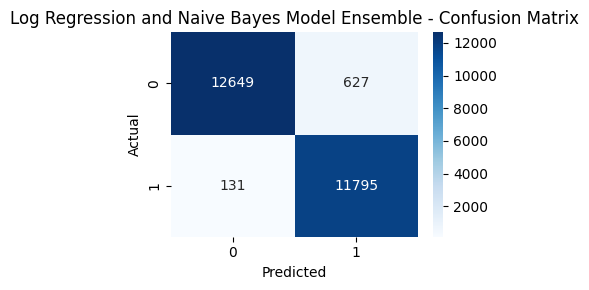

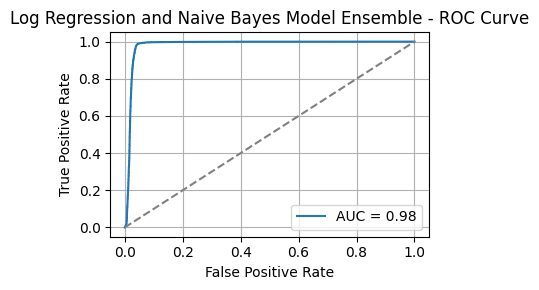

In [29]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

acc = accuracy_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds)
rec = recall_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, ensemble_preds)

print(f"{"Log Regression and Naive Bayes Model Ensemble Performance"}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{"Log Regression and Naive Bayes Model Ensemble"} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{"Log Regression and Naive Bayes Model Ensemble"} - ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()